In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import h5py
import glob



from mockobservation_tools.galaxy_tools import (load_halo,
                                                load_sim,
                                                mask_sim_to_halo,
                                                get_mock_observation,
                                                )

from mockobservation_tools.general_tools import (mag_to_lum_SB
                                                )


%matplotlib inline


Missing firefly, obtain it at http://github.com/ageller/Firefly or pip install firefly.


You can save the mock images any way you want

This is just an example of how I save it as a hdf5

## Read in simulation

In [2]:
#Example using the m11c_res2100 and the 600 snap shot

sim = 'm11c_res2100' #defined only to ease defining directories  

snap_num = 600 #snapshot number

# path to the directory holding the simulation snapshot 
sim_path =  '/DFS-L/DATA/cosmo/grenache/aalazar/FIRE/GVB/'+str(sim)+'/output/hdf5/snapdir_'+str(snap_num)+'/'

# path to the directory holding the halo files for the simulation
halo_path = '/DFS-L/DATA/cosmo/grenache/aalazar/FIRE/GVB/'+str(sim)+'/halo/rockstar_dm/hdf5/'


In [3]:
star_snapdict, gas_snapdict = load_sim(sim_path,snap_num)

halo = load_halo(halo_path, snap_num, filetype='hdf5')


In [4]:
#For now you can use this FOV & number of pixels
FOV = 25
pixels = 500

star_snapdict, gas_snapdict, halo = mask_sim_to_halo(star_snapdict=star_snapdict,
                                                     gas_snapdict=gas_snapdict, 
                                                     host_halo=halo, 
                                                     lim = True,
                                                     limvalue = FOV
                                                    )



## Now run and save images

I make a single file that contain all 3 orientation and band images 

In [5]:
#what directory will you save your file
savedirectory = 'Figures/'


#Name your file, I like to add as much information as posible
file_name = 'sim' + '_host_ugrband_FOV' + str(FOV) + '_p' + str(pixels)+'.hdf5'
    
# For FIREBox I use this format
#file_name = 'object_' + str(galaxyID) + '_host_ugrband_FOV' + str(FOV) + '_p' + str(pixels)+'.hdf5'

file_path = savedirectory + file_name


xy
Calculating L/M in Sloan u (BAND_ID=1,l=3551 A)
Calculating L/M in Sloan g (BAND_ID=2,l=4686 A)
Calculating L/M in Sloan r (BAND_ID=3,l=6165 A)
Projecting with attenuation...
total lum before attenuation in each band (Lsun/1e10): [0.15675338 0.09673077 0.07008224]
opacity in each band: [np.float64(1585.979156207648), np.float64(1154.4425319436855), np.float64(799.3864465256439)]
total gas mass: 0.03491722347875767
yz
Calculating L/M in Sloan u (BAND_ID=1,l=3551 A)
Calculating L/M in Sloan g (BAND_ID=2,l=4686 A)
Calculating L/M in Sloan r (BAND_ID=3,l=6165 A)
Projecting with attenuation...
total lum before attenuation in each band (Lsun/1e10): [0.15675338 0.09673077 0.07008224]
opacity in each band: [np.float64(1585.979156207648), np.float64(1154.4425319436855), np.float64(799.3864465256439)]
total gas mass: 0.03491722347875767
zx
Calculating L/M in Sloan u (BAND_ID=1,l=3551 A)
Calculating L/M in Sloan g (BAND_ID=2,l=4686 A)
Calculating L/M in Sloan r (BAND_ID=3,l=6165 A)
Projecting 

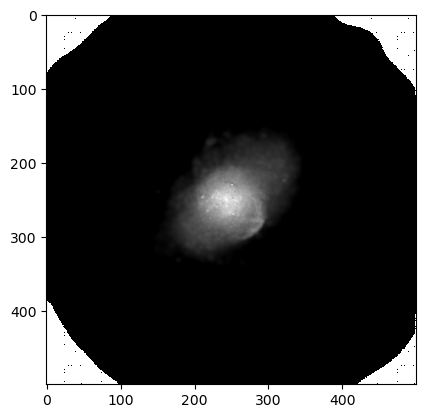

In [6]:
#opens your new hdf5 file
with h5py.File(file_path, 'w') as f:

    #runs it in each orientation
    for proj in ['xy','yz','zx']:
        print(proj)
        band_image_u, band_image_g, band_image_r = get_mock_observation(star_snapdict, 
                                                                        gas_snapdict,
                                                                        bands=[1,2,3],
                                                                        view=proj,
                                                                        FOV=FOV,
                                                                        pixels=pixels, 
                                                                        return_type = 'SB_lum')

        group = f.create_group('projection_' + proj)
        
        #You can adjust what ever information you want to save with the image
        group.attrs['sim'] = 'sim'
        group.attrs['projection'] = proj
        group.attrs['FOV'] = FOV
        group.attrs['pixels'] = pixels
        group.attrs['host'] = 'host' 
        #group.attrs['groupID'] = globalparams['groupID'][i] #Useful for firebox
        #group.attrs['galaxyID'] = globalparams['galaxyID'][i] #Useful for firebox
        group.attrs['format'] = 'band_image' #This just means the units are same as the output of SB_lum
        #group.attrs['FOVEdge']= '2xr80' #I used this to explain how I determined the FOV

        group.create_dataset('band_u', data=np.float32(band_image_u))
        group.create_dataset('band_g', data=np.float32(band_image_g))
        group.create_dataset('band_r', data=np.float32(band_image_r))

    plt.imshow(band_image_r,norm=LogNorm(vmin=1e5, vmax=1e8), cmap='grey')
    plt.show()


f.close()


## Example of how to read the file

In [7]:
#collect all of the image files from the directory
images_files = glob.glob(savedirectory + "*.hdf5")
images_files

['Figures/sim_host_ugrband_FOV25_p500.hdf5']

In [8]:
file = h5py.File(images_files[0], 'r')
file.keys()

<KeysViewHDF5 ['projection_xy', 'projection_yz', 'projection_zx']>

In [9]:
file['projection_xy'].keys()

<KeysViewHDF5 ['band_g', 'band_r', 'band_u']>

In [10]:
file['projection_xy'].attrs.keys()

<KeysViewHDF5 ['FOV', 'format', 'host', 'pixels', 'projection', 'sim']>

In [11]:
print(f'Sim: {file['projection_xy'].attrs['sim']}')
print(f'FOV: {file['projection_xy'].attrs['FOV']}')
print(f'projection: {file['projection_xy'].attrs['projection']}')
print(f'pixels: {file['projection_xy'].attrs['pixels']}')

Sim: sim
FOV: 25
projection: xy
pixels: 500


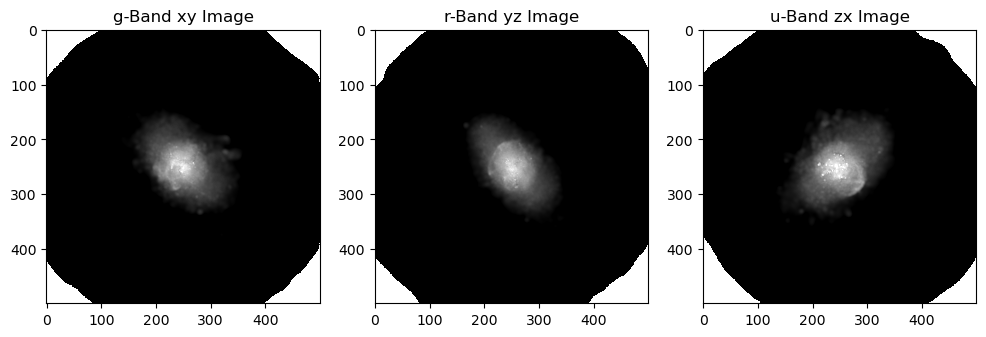

In [12]:
fig = plt.figure(figsize = (12, 4))    

ax = fig.add_subplot(1, 3, 1)  

plt.imshow(file['projection_xy']['band_g'],norm=LogNorm(vmin=1e5, vmax=1e8), cmap='grey')
plt.title('g-Band xy Image')

ax = fig.add_subplot(1, 3, 2)  

plt.imshow(file['projection_yz']['band_r'],norm=LogNorm(vmin=1e5, vmax=1e8), cmap='grey')
plt.title('r-Band yz Image')

ax = fig.add_subplot(1, 3, 3)  

plt.imshow(file['projection_zx']['band_u'],norm=LogNorm(vmin=1e5, vmax=1e8), cmap='grey')
plt.title('u-Band zx Image')


plt.show()